# Solution of the Laplace Equation on a Polar grid

In this workbook we are going to look at the solution of the Laplace equations on a polar coordinate grid.  In this case we are going to use the Bi-Conjugate Gradient solver to solve the problem.  It should be noted that there is a periodic boundary condition at $\theta=0$ and $\theta=2\pi$ so the coeficient matrix needs to reflecxt this.

$$
\frac{\partial^2 u}{\partial r^2} + \frac{1}{r}\frac{\partial u}{\partial r} + \frac{1}{r^2}\frac{\partial^2 u}{\partial \theta^2} = 0
$$

The boundary conditions on the inside and outside of the pipe are given by
$$\begin{align}
    u(1, \theta) &= 0, \quad 0\le\theta\le 2\pi \label{eq:inner_BC}\\
    \frac{\partial u}{\partial r}(3, \theta) &= \begin{cases}
        0, \quad & 0\le\theta<\pi \\
        1, \quad & \pi\le\theta\le 2\pi
        \end{cases}
\end{align} $$


In [1]:
import numpy as np
import scipy.sparse.linalg as LA
import scipy.sparse as sps
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid for
    a polar cartesian grid.  We assume that theta
    goes from 0 to 2\pi and has periodic boundaires
    in the theta direction.'''
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = 0.0 # unit circle  
        self.extent = 1.0
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.r = np.zeros((nj, ni))
        self.theta = np.zeros((nj, ni))

    def set_origin(self, r0):
        self.origin = r0
    
    def set_extent(self,r1):
        self.extent = r1
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        
        theta = np.linspace(0.0, 2*np.pi, self.Ni+1)
        theta_ord = np.delete(theta,[-1])
        r_ord = np.linspace(self.origin, self.extent, self.Nj)
        self.theta,self.r = np.meshgrid(theta_ord, r_ord)
        if not Quiet:
            print(self)

    def Delta_r(self):
        # calculate delta x
        return self.r[1,0]-self.r[0,0]
    
    def Delta_theta(self):
        # calculate delta y
        return self.theta[0,1]-self.theta[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (theta,r).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0])/self.Delta_theta()
        grid_y = (point[1] - self.origin)/self.Delta_r()
        return int(grid_x), int(grid_y)
    
    def plot(self,title):
        '''produce a contour plot of u(theta,r)'''
        # convert polar to Cartesian coordinates
        x = self.r*np.cos(self.theta)
        y = self.r*np.sin(self.theta)
        
        # produce the plot
        fig, ax = plt.subplots()
        cmap = plt.get_cmap('jet')
        ax.axis('equal')
        ax.set_aspect('equal', 'box')
        cf = ax.contourf(x,y,self.u,cmap=cmap,levels = 21)
        fig.colorbar(cf, ax=ax)
        ax.set_title(f'{title} ({self.Ni} x {self.Nj} grid)')
        return plt
    
    def __str__(self):
        # describe the object when asked to print it
        return 'Uniform {}x{} polar grid from r = {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)

In [2]:
#Set up the coursework 
def coursework_one(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_origin(1.0)
    mesh.set_extent(3.0)
    mesh.generate()
    return mesh

Now we can implement the solver.  We can use the solver from the BiCGStab workbook as a template, remembering that in this case we know that the r=1 boundary is a Dirichlet BC with $u=(1,\theta)=0$.  The $r=3$ boundary condition is a Neumann condition where

$$\begin{align}
    u(1, \theta) &= 0, \quad 0\le\theta\le 2\pi \label{eq:inner_BC}\\
    \frac{\partial u}{\partial r}(3, \theta) &= \begin{cases}
        0, \quad & 0\le\theta<\pi \\
        1, \quad & \pi\le\theta\le 2\pi
        \end{cases}
\end{align} $$

We also need to enfroce the periodic boundary condition $u(r,0)=u(r,2\pi)$ and to modify the coefficients in the coefficient matrix to include both the additional derivative and the $1/r$ and $1/r^2$ coefficients.

The cylindrical polar form of the Laplace equation is discretised using the centred, 2nd order, finite difference equation, in compas notation are:

$$
\frac{u_N - 2u_O + u_S}{\Delta r^2} + \frac{1}{r_j} \frac{u_N - u_S}{2\Delta r} + \frac{1}{r_j^2} \frac{u_E - 2u_O + u_W}{\Delta \theta^2} = 0
$$

### Coefficients

Collecting terms

$$\frac{
2\Delta r^2 u_W+2\Delta r^2 u_E
+(2\Delta\theta^2 r^2-\Delta r\Delta\theta^2r) u_s
+(2\Delta\theta^2 r^2+\Delta r\Delta\theta^2r) u_N
-(4\Delta\theta^2r^2-4\Delta r^2) u_O}
{2\Delta r^2\Delta\theta^2r^2}=0$$

This gives coefficents for the $A$ matrix of

| Point | Coefficient 
| --- | --- 
| u<sub>N</sub> | $\frac{2r+\Delta r}{2r\Delta r^2}$ 
| u<sub>E</sub> | $\frac{1}{r^2\Delta\theta^2}$ 
| u<sub>S</sub> | $\frac{2r-\Delta r}{2r\Delta r^2}$ 
| u<sub>W</sub> | $\frac{1}{r^2\Delta\theta^2}$ 
| u<sub>O</sub> | $-2\frac{r^2\Delta\theta^2+\Delta r^2}{r^2\Delta r^2\Delta\theta^2}$ 

### Boundary conditions

It is useful to think about a small grid and to workout what points are needed in the stencil to deal with the periodic conditions.  Here is a cartoon of a 5x5 grid and the associated sparisity pattern of the $A$ matrix.  Periodic boundary conditions are in yellow.  Because we are directly assembling the matrix, **no grid cells are being used to hold boundary condition information**, so we won't need 1 cell on each side of the grid to hold ghost cell information.

This means the solver uses the whole grid.

![](Figures/LaplaceGrid-k.png)  ![](Figures/SparsityPattern-filled.png)

On the left and right boundaries (where $\theta=0$ or $\theta=2\pi$ we have a periodic condition, this means that when $j=0$ the west node is at $j=N_j-1$ and when $j=N_j-1$ the east node is at $j=0$.  We need to do this in the matrix assembly routine.

On the bottom ($r=1$) boundary $u(1,\theta)=0$, this means that $0\times(2r-\Delta r)/(2r\Delta r^2)=0$ must be subtracted from $b_k$, so there is nothing to be done.

The top ($r=3$) boundary has a Neumann boundary condition, when the gradient is zero we have

$$\frac{u_N-u_S}{2\Delta r}=0 \implies u_N = u_s.$$

substituting into the stencil 

$$
\frac{2u_S - 2u_O}{\Delta r^2} + \frac{1}{r_j^2} \frac{u_E - 2u_O + u_W}{\Delta \theta^2} = 0
$$

and collecting terms we find

$$\frac{\Delta r^2u_W + 2r^2\Delta\theta^2u_S -2(r^2\Delta\theta^2 + \Delta r^2)u_O+\Delta r^2U_E}
{r^2\Delta r^2\Delta\theta^2 }=0.$$

We can see that the coefficients of $u_W$, $u_E$ and $u_O$ remain unchanged, the coefficient of $u_N$ is zero, but the coefficient of $u_S$ becomes

$$C_s=\frac{2}{\Delta r^2}.$$

When $\theta>\pi$ and the gradient is one we have:

$$\begin{align*}
\frac{u_N-u_S}{2\Delta r}&=1 \\
u_N-u_S&=2\Delta r \\
u_N &= u_S+2\Delta r
\end{align*}$$

substituting into the stencil
$$\frac{u_W-2u_O+u_E}{r^2\Delta \theta^2}+\frac{2u_S-2u_O+2\Delta r}{\Delta r^2}+\frac{1}{r}=0$$

and collecting terms we find that $u_s$ ceofficient becomes

$$C_s=\frac{2}{\Delta r^2}.$$

We also now have a constant term on the LHS of the stencil, $\frac{2r+\Delta r}{r\Delta r}$.
So we also need to set $b_k=-\frac{2r+\Delta r}{r\Delta r}$ at the North boundary when $\theta>\pi$.



In [6]:
def PolarLaplaceSolver(grid,tol=0.5e-7, quiet=True):
    '''Solve the two dimensional laplace equation on a polar coordinates
    using the bi-conjugate gradient stabilised matrix solver (BiCGStab).  
    This function assembles the coeficient matrix A and the RHS vector b
    taking account of the boundary conditions specified in the question.
    It should call the  BiCGStab solver from scipy.  The value tol is p
    assed to BiCGStab routine The solution vector x is then unpacked 
    into grid.u. It returns the info value from BiCGStab if this is 
    zero everything worked.'''
    
    # Create the A matrix using the lil format and the b vector
    # as numpy vector.
    N = grid.Nj*grid.Ni
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)

    d_r = grid.Delta_r()  
    d_theta = grid.Delta_theta()
    
    for j in range(grid.Nj): # radial direction
            for i in range(grid.Ni): # circumferential direction
                # equation number
                k = i + grid.Ni*j
                
                # calculate the coefficients
                north = (2 * grid.r[j,i] + d_r) / (2*grid.r[j,i] * d_r**2)
                c_theta = 1 / (grid.r[j,i]**2 * d_theta**2)  # east and west
                south = (2 * grid.r[j,i] - d_r)/(2 * grid.r[j,i] * d_r**2)
                centre = - 2 * (d_theta**2 * grid.r[j,i]**2 + d_r**2) / (grid.r[j,i]**2 * d_r**2 * d_theta**2)
                
                # now assemble the matrix
                A_mat[k,k] += centre
                # North boundary
                if j < (grid.Nj-1):
                    A_mat[k,k+grid.Ni] = north
                    kn=k+grid.Ni
                else:
                    kn=k-grid.Ni
                    # Neumann boundary (depends on theta)
                    if grid.theta[j,i]<np.pi:
                        A_mat[k,kn] = 2/d_r**2
                    else:
                        A_mat[k,kn] = 2/d_r**2
                        b_vec[k] = - (2*grid.r[j,i]+d_r)/(grid.r[j,i]*d_r)

                # South boundary
                if j>0 and j< (grid.Nj-1):
                    ks=k-grid.Ni
                    A_mat[k,ks] += south
                else:
                    ks=k+grid.Ni
                    b_vec[k] += 0.0
            
                # East boundary (periodic)
                if i<test.Ni-1:
                    ke=k+1
                else:
                    ke=k-grid.Ni+1
                A_mat[k,ke] += c_theta
            
                # West boundary (periodic)
                if i>0:
                    kw=k-1
                else:
                    kw=k+grid.Ni-1
                A_mat[k,kw] += c_theta

                if not quiet:
                    print(i,j,':',ks,kw,k,ke,kn)
                    plt.spy(A_mat)
                    plt.savefig('Figures/Matrix-structure.png')
                    
    # call bicgstab with an ILU preconditioner, drop_tol and
    # fill factor control the accuracy of the ILU approximation.
    ilu = LA.spilu(A_mat.tocsc(), drop_tol=1e-5, fill_factor=100)
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)
    x_vec, info = LA.bicgstab(A_mat, b_vec, atol=tol, M=M_mat)

    if info==0:
        # unpack x_vec into u
        for j in range(grid.Nj):
            for i in range(grid.Ni):
                k = i + grid.Ni*j
                grid.u[j,i]=x_vec[k]
    
    return info

In [7]:
# lets set up the test problem on a 5x5 grid
test = coursework_one(6,5)
print(test)

Uniform 6x5 polar grid from r = 1.0 to 3.0.


0 0 : 6 5 0 1 6
1 0 : 7 0 1 2 7
2 0 : 8 1 2 3 8
3 0 : 9 2 3 4 9
4 0 : 10 3 4 5 10
5 0 : 11 4 5 0 11
0 1 : 0 11 6 7 12
1 1 : 1 6 7 8 13
2 1 : 2 7 8 9 14
3 1 : 3 8 9 10 15
4 1 : 4 9 10 11 16
5 1 : 5 10 11 6 17
0 2 : 6 17 12 13 18
1 2 : 7 12 13 14 19
2 2 : 8 13 14 15 20
3 2 : 9 14 15 16 21
4 2 : 10 15 16 17 22
5 2 : 11 16 17 12 23
0 3 : 12 23 18 19 24
1 3 : 13 18 19 20 25
2 3 : 14 19 20 21 26
3 3 : 15 20 21 22 27
4 3 : 16 21 22 23 28
5 3 : 17 22 23 18 29
0 4 : 30 29 24 25 18
1 4 : 31 24 25 26 19
2 4 : 32 25 26 27 20
3 4 : 33 26 27 28 21
4 4 : 34 27 28 29 22
5 4 : 35 28 29 24 23


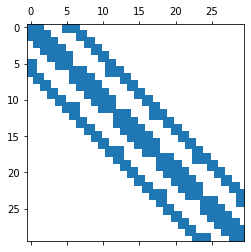

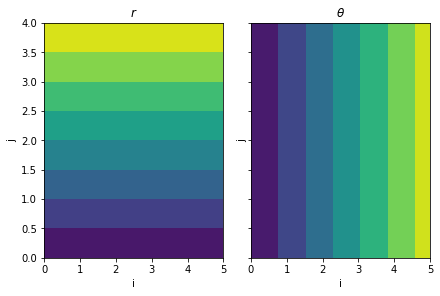

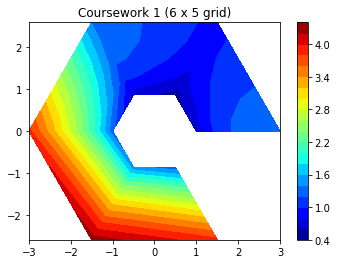

In [8]:
info = PolarLaplaceSolver(test,quiet=False)
if info==0:
    i_c = np.ones_like(test.u)
    j_c = np.ones_like(test.u)
    for j in range(test.Nj):
        for i in range(test.Ni):
            i_c[j,i]=i
            j_c[j,i]=j
    axs = (plt.figure(constrained_layout=True)
       .subplots(1, 2, sharex=True, sharey=True))
    
    axs[0].contourf(i_c,j_c,test.r)
    axs[0].set(title=r'$r$', xlabel='i', ylabel='j')
    axs[1].contourf(i_c,j_c,test.theta)
    axs[1].set(title=r'$\theta$', xlabel='i', ylabel='j')

    plt.show()
    
    plt = test.plot('Coursework 1')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')

Uniform 361x101 polar grid from r = 1.0 to 3.0.


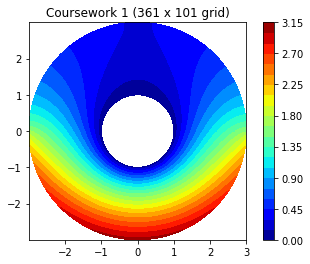

In [9]:
# Run on a proper grid
test = coursework_one(361,101)
print(test)
info = PolarLaplaceSolver(test)
if info==0:
    plt = test.plot('Coursework 1')
    plt.savefig('Figures/Coursework1.pdf')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')

### refinement analysis

I'm going to use $$\int_{\frac\pi2}^{\frac{3\pi}2} u(2.0,\theta)\ d\theta$$ as the integrated quantity.  Other choices are reasonable.


In [10]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dtheta(mesh,theta0,theta1,r):
    '''Calculate U=\int_\theta_0^\theta_1u(x,r) dx  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i0,j = mesh.find((theta0,r))
    i1,j = mesh.find((theta1,r))

    if i1==mesh.Ni:
        i1=-1
    
    # integrate
    return integrate.simps(mesh.u[j,i0:i1],mesh.theta[j,i0:i1])




Uniform 961x961 polar grid from r = 1.0 to 3.0.
The solver took 0:01:00, the return code is 0
Integrated value is  3.2497614887790385 

Uniform 481x481 polar grid from r = 1.0 to 3.0.
The solver took 0:00:12, the return code is 0
Integrated value is  3.2428907582109714 

Uniform 241x241 polar grid from r = 1.0 to 3.0.
The solver took 0:00:02, the return code is 0
Integrated value is  3.219262495785117 

Uniform 121x121 polar grid from r = 1.0 to 3.0.
The solver took 0:00:00, the return code is 0
Integrated value is  3.1715917938175293 

Uniform 61x61 polar grid from r = 1.0 to 3.0.
The solver took 0:00:00, the return code is 0
Integrated value is  3.0039744527160055 



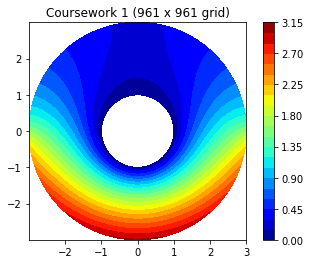

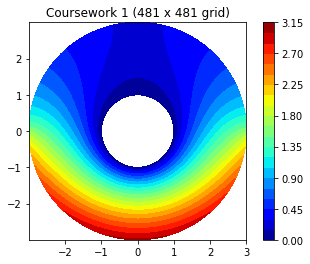

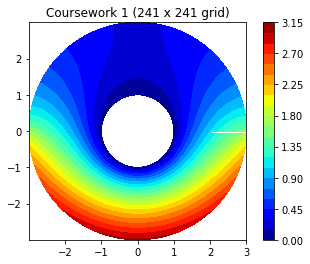

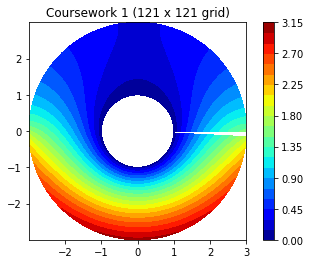

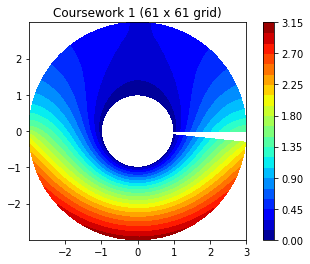

In [12]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(5,0,-1):
    ni = 30*2**grid_index + 1
    nj = 30*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    test = coursework_one(ni,nj)
    print(test)
    
    # solve it with machine precision
    start = time.process_time()
    info = PolarLaplaceSolver(test)
    stop = time.process_time()
    print("The solver took {}, the return code is {}" \
          .format(datetime.timedelta(seconds=int(stop-start)),info))

    # save dx and the integral
    dx_val.append(test.Delta_theta())
    U_val.append(integrate_u_dtheta(test,np.pi/2,3*np.pi/2,2.0))
    run_time.append(stop-start)

    test.plot('Coursework 1')
    print('Integrated value is ',U_val[-1],'\n')

Refinement Analysis on 5 grids.

Grid Delta x ratio  $\int_{0}^{2\pi}u(2.0,\theta) d\theta$
----------------------------------------------------------
   1 0.006538     2   3.24976
   2 0.01306     2   3.24289
   3 0.02607     2   3.21926
   4 0.05193     2   3.17159
   5   0.103   ---   3.00397
---------------------------------------------------------- 

order of convergence, p =   1.78

Grids       GCI
---------------
 1  2  0.001084
 2  3  0.003734
 3  4  0.007589
 4  5   0.02709
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3      0.9979 True
 2 3  3 4       1.692 False
 3 4  4 5      0.9636 False
-------------------------------



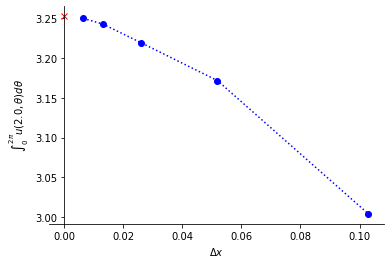

In [13]:
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'$\int_{0}^{2\pi}u(2.0,\theta) d\theta$')
analysis.graph(True,r'$\int_{0}^{2\pi}u(2.0,\theta) d\theta$',filename='Figures/CW1-refinement.pdf')